In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.07it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.64it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.37it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e-2):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 05 02:58:23 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.7465:   5%|██▊                                                    | 1/20 [00:27<05:40, 17.95s/it]

Epoch   1, Train Regret:  13.3203%, Val Regret:  14.5007%


Epoch    1, Loss:  -0.8908:  10%|█████▌                                                 | 2/20 [00:40<04:29, 14.98s/it]

Epoch   2, Train Regret:  14.4619%, Val Regret:  14.4818%


Epoch    2, Loss:  -0.8418:  15%|████████▎                                              | 3/20 [00:52<03:57, 13.96s/it]

Epoch   3, Train Regret:  13.3648%, Val Regret:  13.7928%


Epoch    3, Loss:  -0.8219:  20%|███████████                                            | 4/20 [01:05<03:36, 13.52s/it]

Epoch   4, Train Regret:  12.5238%, Val Regret:  12.3615%


Epoch    4, Loss:  -0.9280:  25%|█████████████▊                                         | 5/20 [01:18<03:19, 13.30s/it]

Epoch   5, Train Regret:  12.0830%, Val Regret:  12.7485%


Epoch    5, Loss:  -0.8861:  30%|████████████████▌                                      | 6/20 [01:31<03:05, 13.22s/it]

Epoch   6, Train Regret:  12.0955%, Val Regret:  11.7019%


Epoch    6, Loss:  -0.9028:  35%|███████████████████▎                                   | 7/20 [01:45<02:49, 13.05s/it]

Epoch   7, Train Regret:  11.8385%, Val Regret:  12.4026%


Epoch    7, Loss:  -0.9389:  40%|██████████████████████                                 | 8/20 [01:59<02:39, 13.27s/it]

Epoch   8, Train Regret:  12.0660%, Val Regret:  12.1621%


Epoch    8, Loss:  -0.9070:  45%|████████████████████████▊                              | 9/20 [02:12<02:41, 14.69s/it]


Epoch   9, Train Regret:  11.9888%, Val Regret:  12.0884%

Early Stop!
Training Elapsed Time: 28.24 Sec

Evaluation:
Test Regret: 12.4149%
Test Elapsed Time: 8.59 Sec


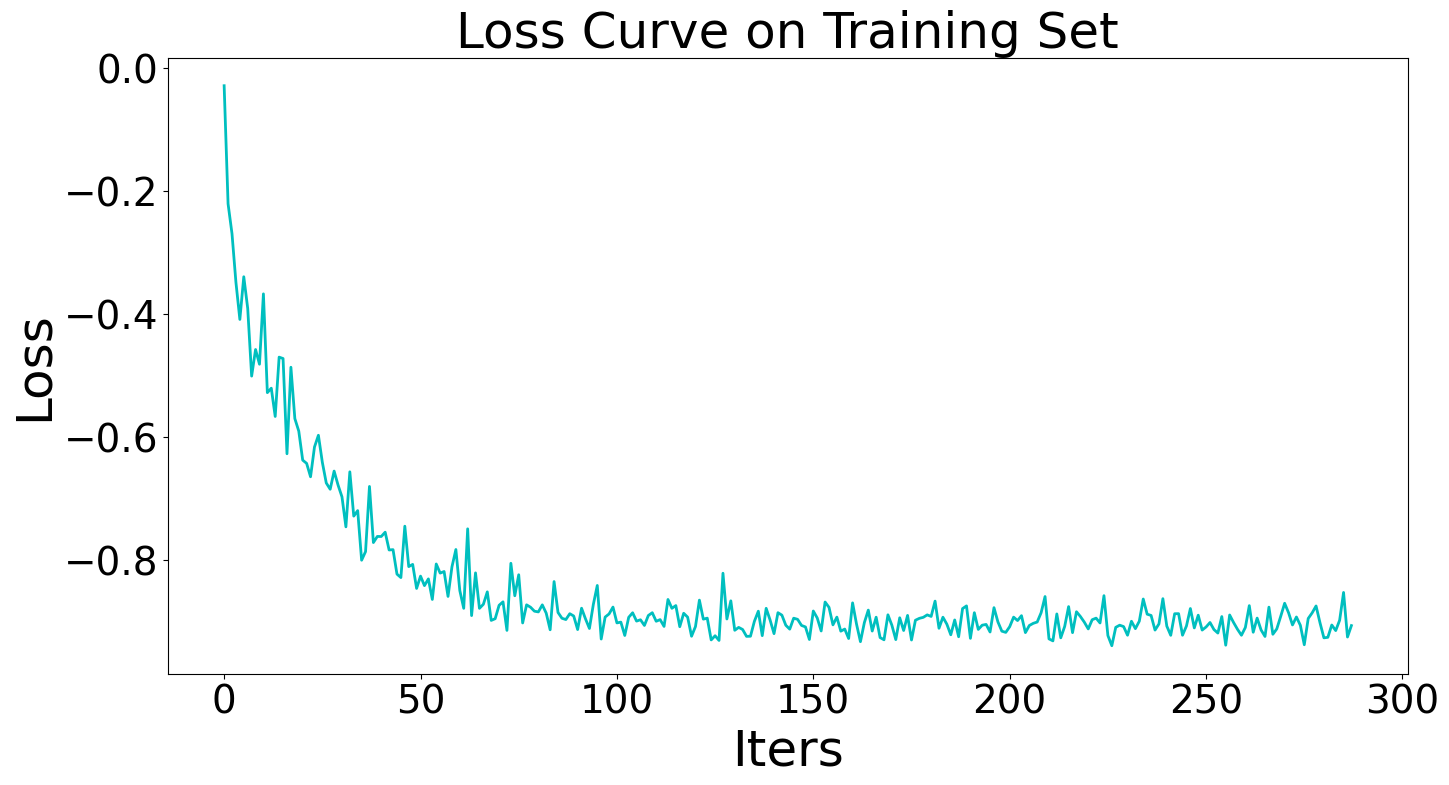

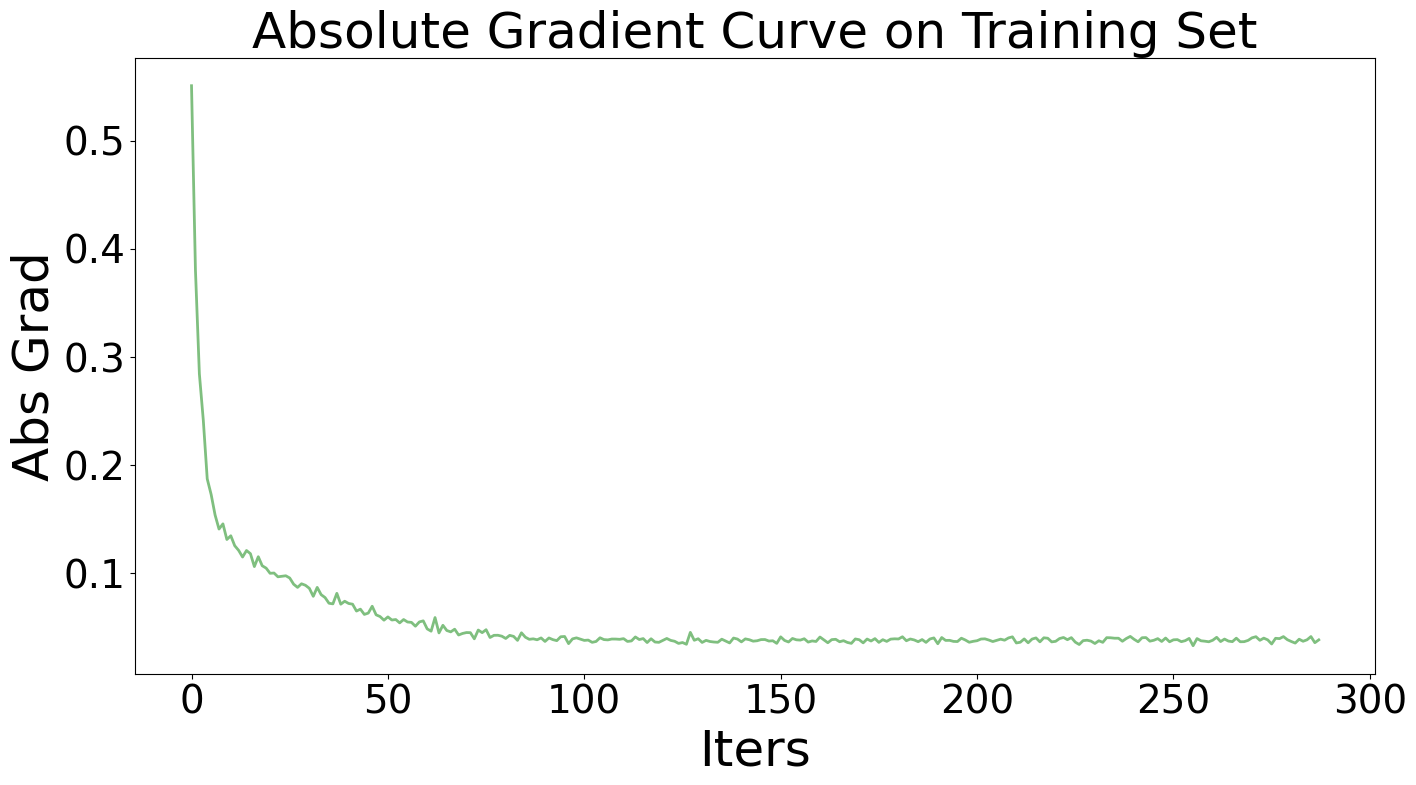

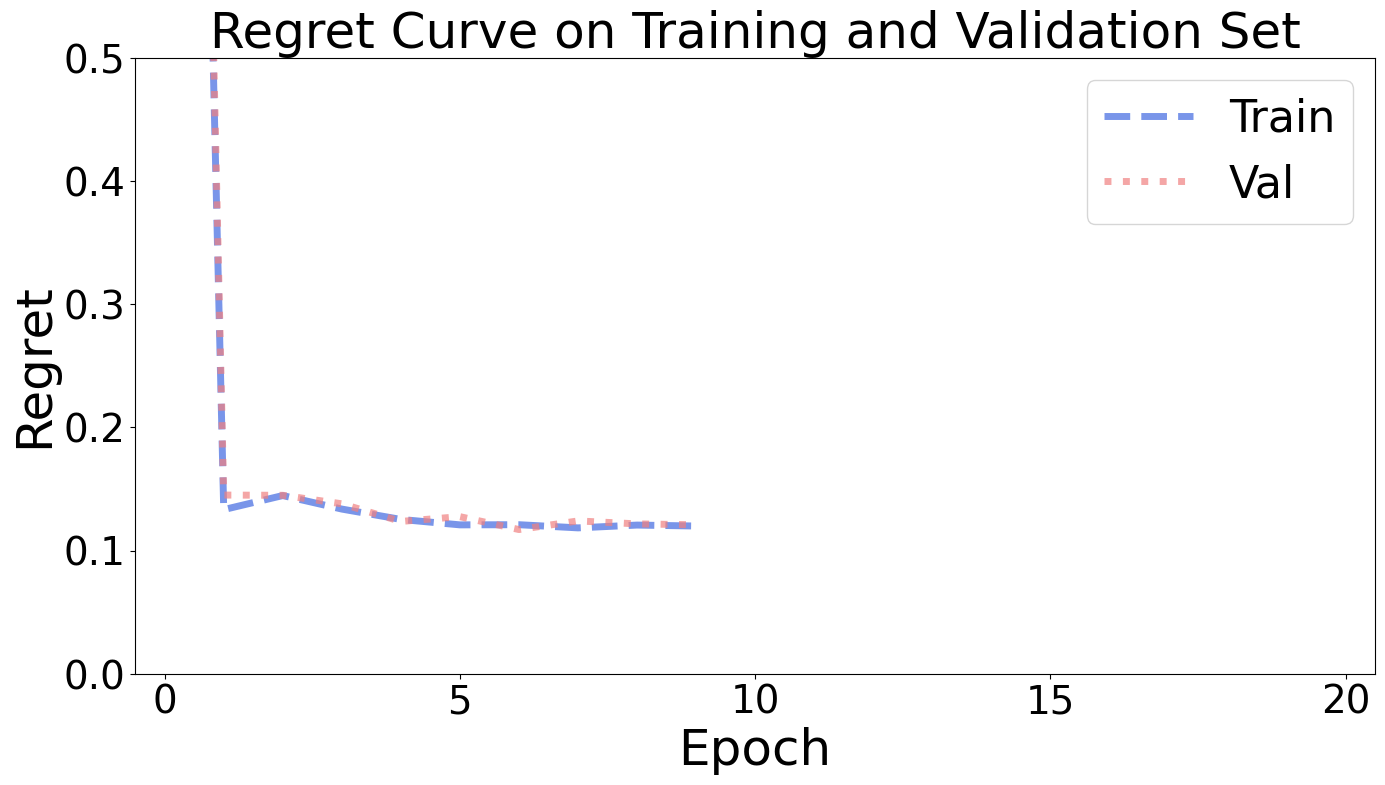

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.7560:   5%|██▊                                                    | 1/20 [00:22<04:05, 12.91s/it]

Epoch   1, Train Regret:  13.6818%, Val Regret:  13.4624%


Epoch    1, Loss:  -0.8911:  10%|█████▌                                                 | 2/20 [00:35<03:51, 12.85s/it]

Epoch   2, Train Regret:  14.7135%, Val Regret:  15.7966%


Epoch    2, Loss:  -0.8422:  15%|████████▎                                              | 3/20 [00:48<03:40, 12.98s/it]

Epoch   3, Train Regret:  13.4761%, Val Regret:  13.9622%


Epoch    3, Loss:  -0.8218:  20%|███████████                                            | 4/20 [01:01<03:29, 13.07s/it]

Epoch   4, Train Regret:  12.2927%, Val Regret:  12.8247%


Epoch    4, Loss:  -0.9278:  25%|█████████████▊                                         | 5/20 [01:14<03:14, 12.99s/it]

Epoch   5, Train Regret:  11.8723%, Val Regret:  12.3486%


Epoch    5, Loss:  -0.8861:  30%|████████████████▌                                      | 6/20 [01:27<03:01, 12.95s/it]

Epoch   6, Train Regret:  11.6401%, Val Regret:  11.3665%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [01:41<02:51, 13.20s/it]

Epoch   7, Train Regret:  11.6226%, Val Regret:  12.0293%


Epoch    7, Loss:  -0.9386:  40%|██████████████████████                                 | 8/20 [01:54<02:39, 13.31s/it]

Epoch   8, Train Regret:  11.7701%, Val Regret:  11.8163%


Epoch    8, Loss:  -0.9068:  45%|████████████████████████▊                              | 9/20 [02:07<02:36, 14.20s/it]


Epoch   9, Train Regret:  11.6418%, Val Regret:  11.6912%

Early Stop!
Training Elapsed Time: 23.86 Sec

Evaluation:
Test Regret: 12.1208%
Test Elapsed Time: 8.40 Sec


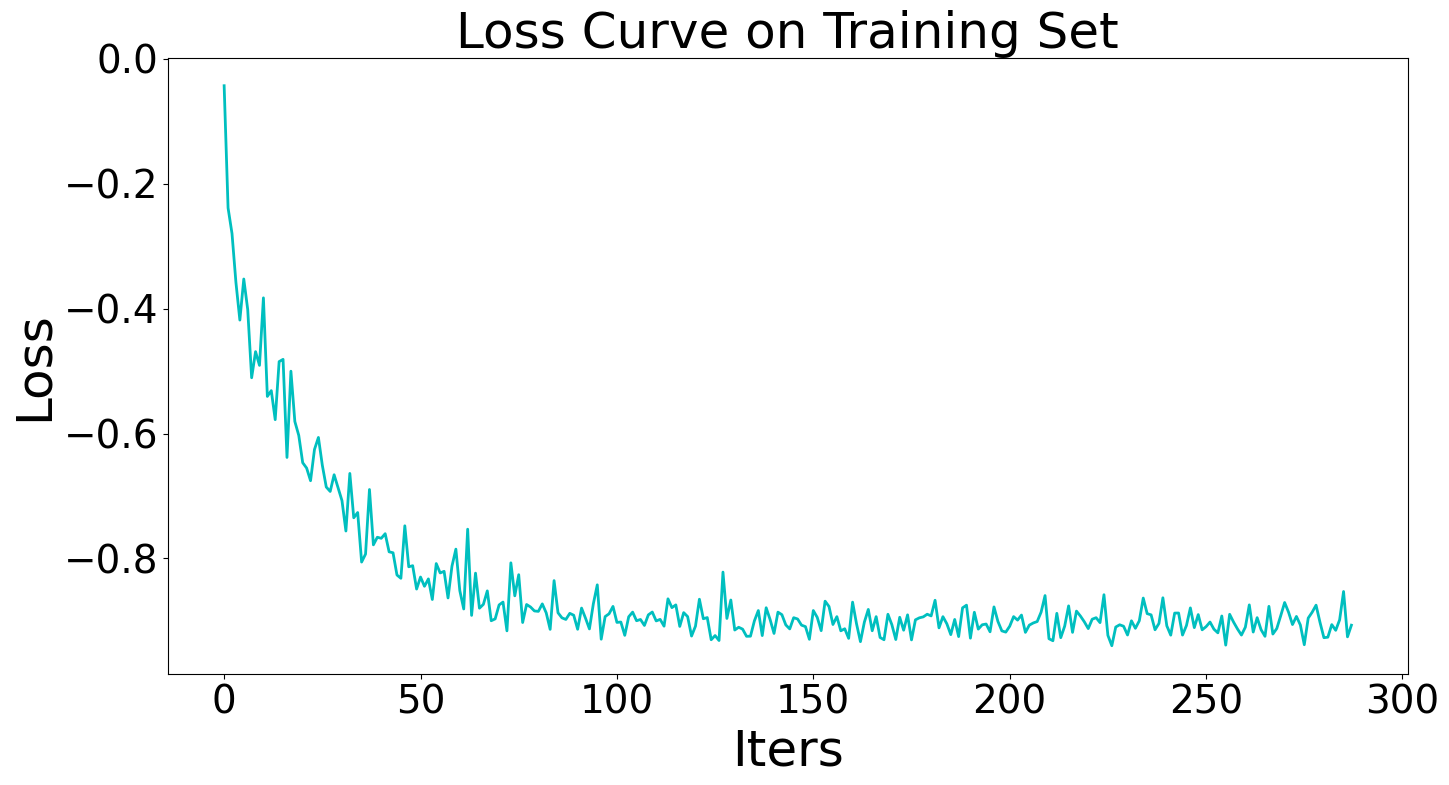

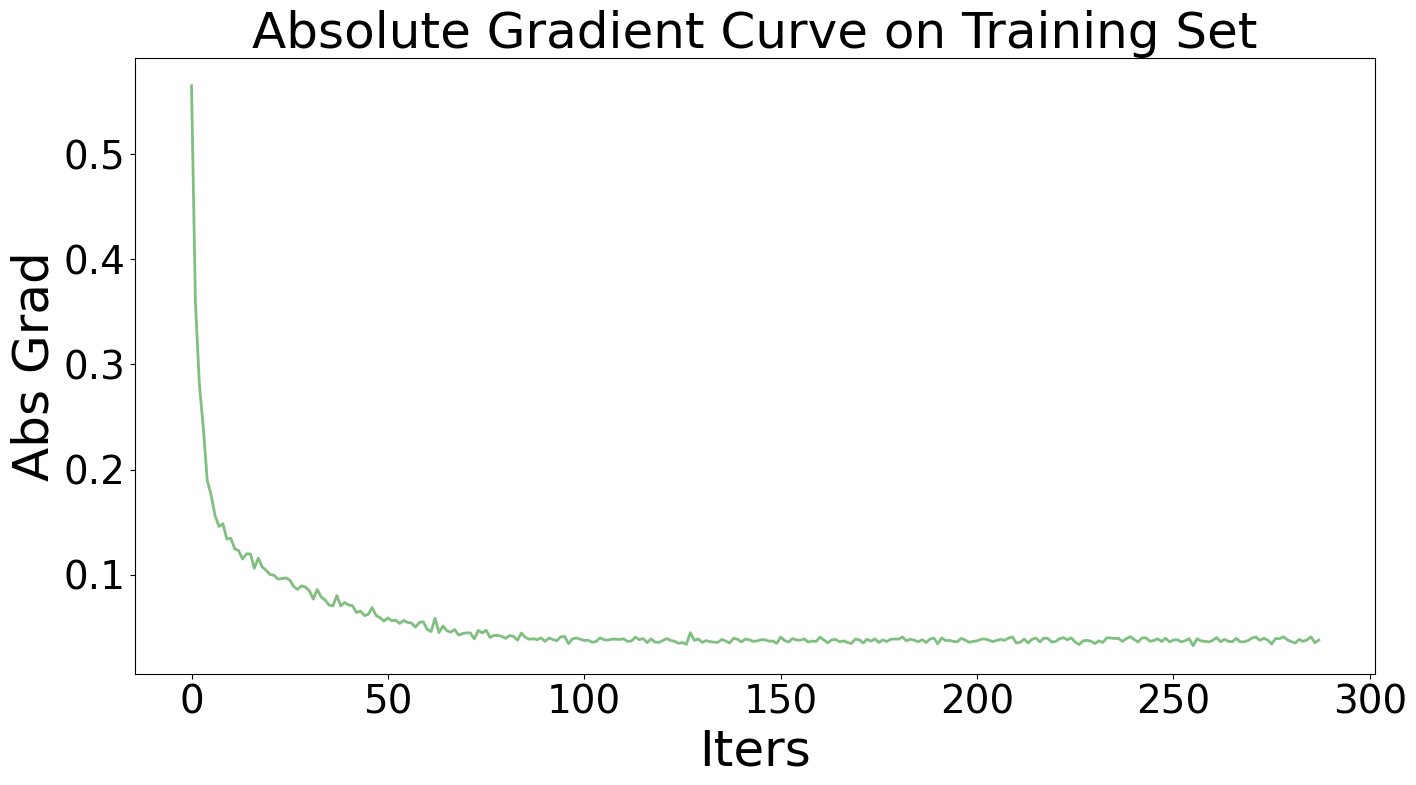

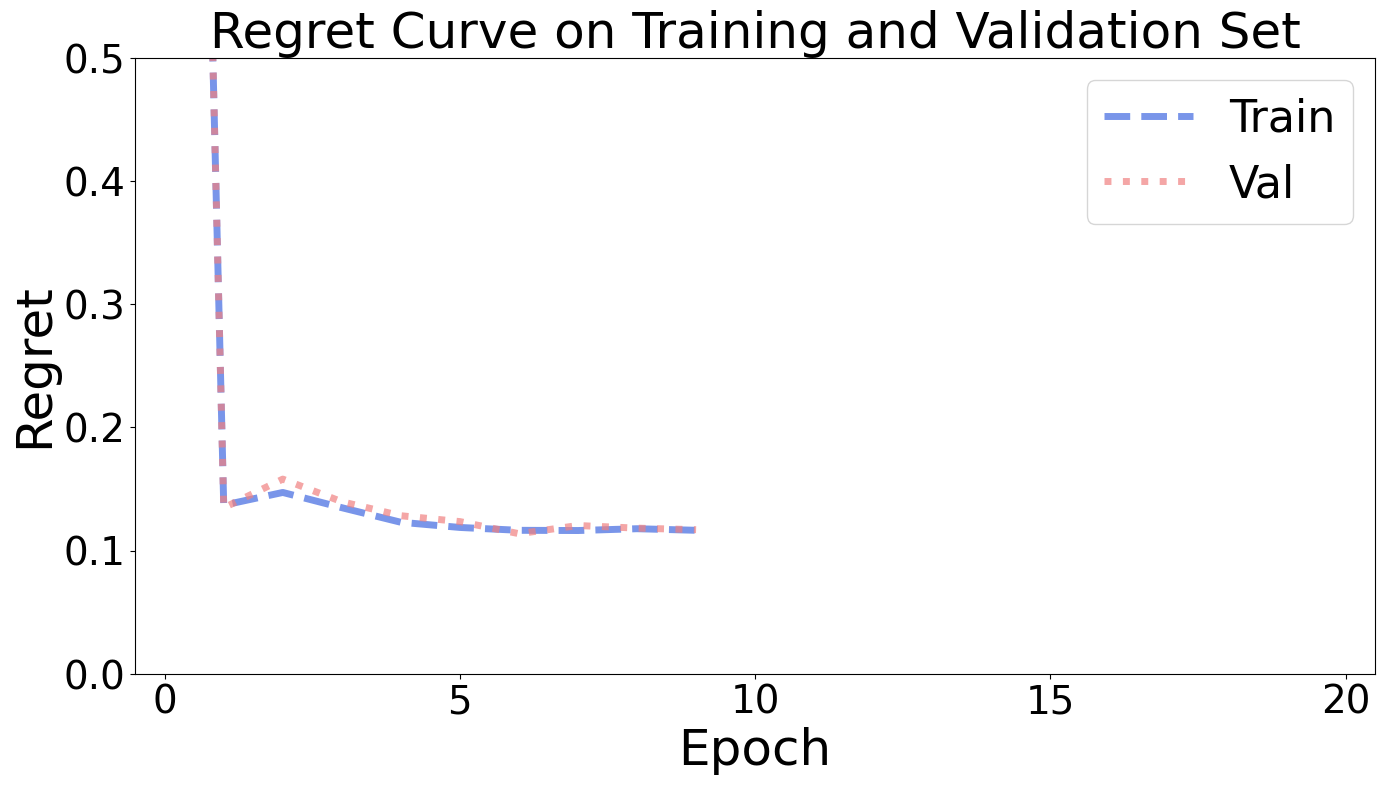

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Inner & Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.6403:   5%|██▊                                                    | 1/20 [00:20<03:42, 11.71s/it]

Epoch   1, Train Regret:  16.3339%, Val Regret:  16.6369%


Epoch    1, Loss:  -0.7897:  10%|█████▌                                                 | 2/20 [00:32<03:26, 11.46s/it]

Epoch   2, Train Regret:  18.8179%, Val Regret:  18.8450%


Epoch    2, Loss:  -0.7510:  15%|████████▎                                              | 3/20 [00:43<03:14, 11.41s/it]

Epoch   3, Train Regret:  18.9840%, Val Regret:  18.1239%


Epoch    3, Loss:  -0.7757:  20%|███████████                                            | 4/20 [00:55<03:41, 13.83s/it]


Epoch   4, Train Regret:  17.9025%, Val Regret:  17.7263%

Early Stop!
Training Elapsed Time: 4.26 Sec

Evaluation:
Test Regret: 16.8528%
Test Elapsed Time: 8.96 Sec


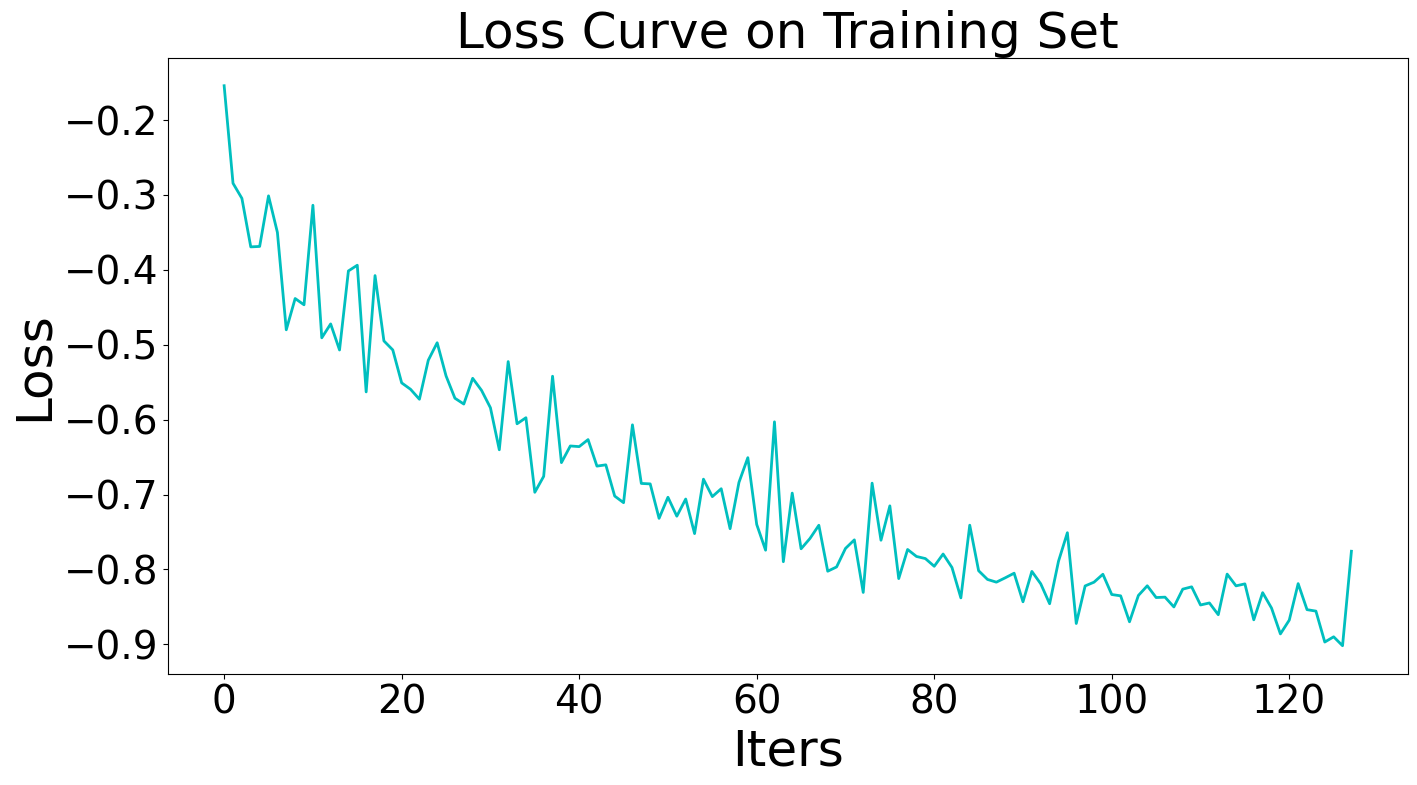

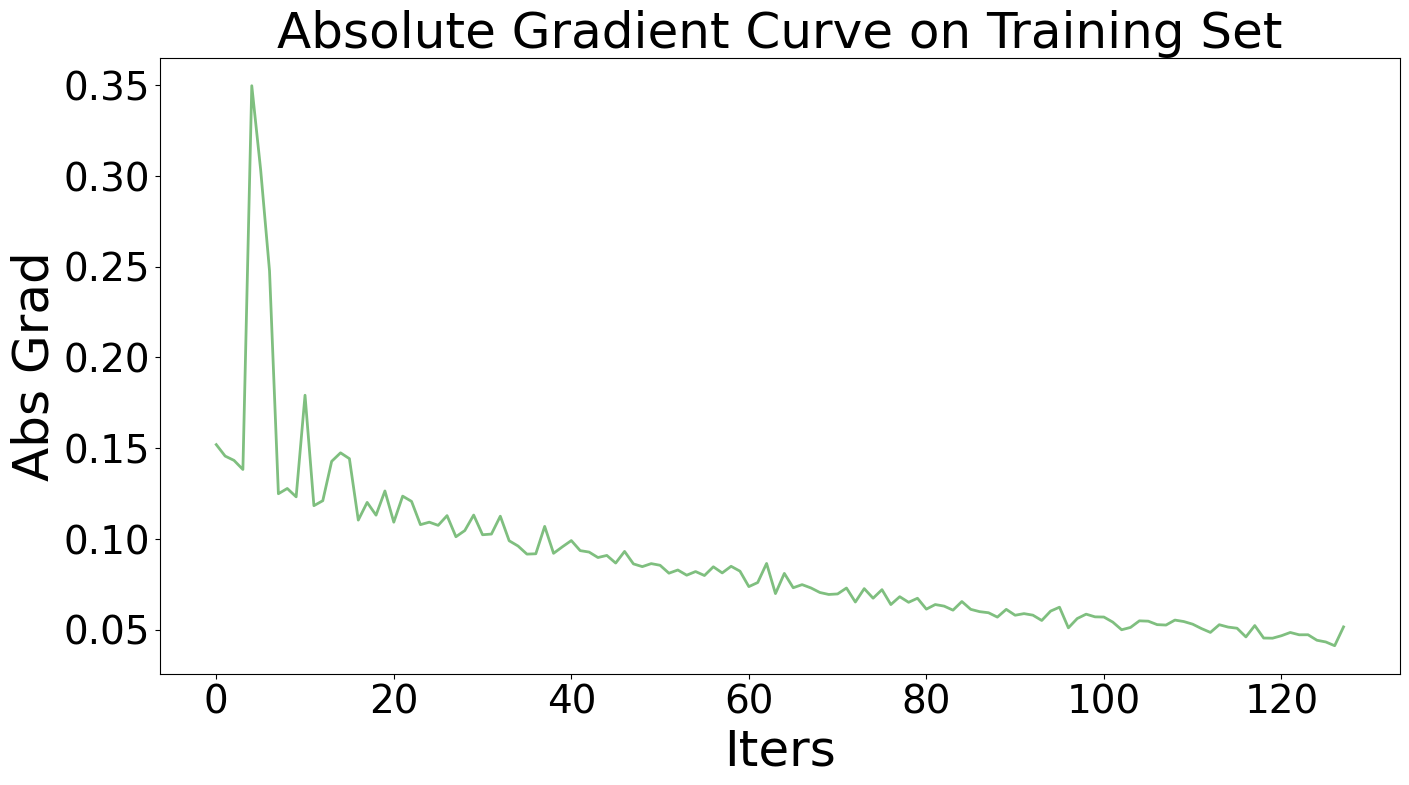

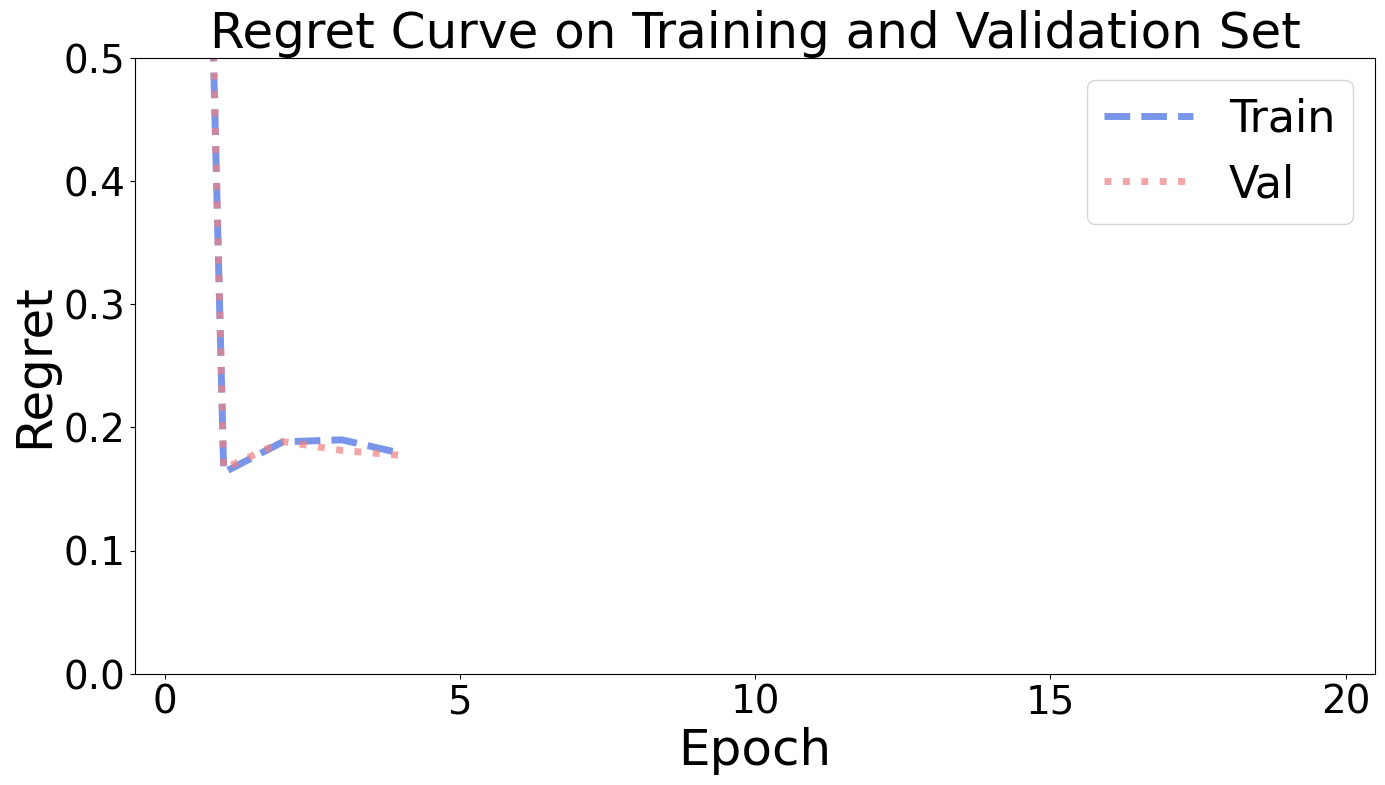

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4)

Num of cores: 1


In [26]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 181.1700%, Val Regret: 179.5455%


Epoch    0, Loss:  -0.7908:   5%|██▊                                                    | 1/20 [00:22<03:52, 12.25s/it]

Epoch   1, Train Regret:  19.5752%, Val Regret:  20.4863%


Epoch    1, Loss:  -0.9026:  10%|█████▌                                                 | 2/20 [00:33<03:33, 11.84s/it]

Epoch   2, Train Regret:  19.0224%, Val Regret:  19.6679%


Epoch    2, Loss:  -0.9180:  15%|████████▎                                              | 3/20 [00:44<03:14, 11.46s/it]

Epoch   3, Train Regret:  15.6330%, Val Regret:  15.4995%


Epoch    3, Loss:  -0.9020:  20%|███████████                                            | 4/20 [00:55<03:00, 11.30s/it]

Epoch   4, Train Regret:  13.3743%, Val Regret:  13.8326%


Epoch    4, Loss:  -0.9175:  25%|█████████████▊                                         | 5/20 [01:06<02:48, 11.26s/it]

Epoch   5, Train Regret:  12.7209%, Val Regret:  12.7463%


Epoch    5, Loss:  -0.8331:  30%|████████████████▌                                      | 6/20 [01:18<02:36, 11.20s/it]

Epoch   6, Train Regret:  12.2863%, Val Regret:  12.6337%


Epoch    6, Loss:  -0.9335:  35%|███████████████████▎                                   | 7/20 [01:30<02:29, 11.51s/it]

Epoch   7, Train Regret:  12.2933%, Val Regret:  13.2318%


Epoch    7, Loss:  -0.9302:  40%|██████████████████████                                 | 8/20 [01:41<02:20, 11.70s/it]

Epoch   8, Train Regret:  12.4190%, Val Regret:  12.3996%


Epoch    8, Loss:  -0.8706:  45%|████████████████████████▊                              | 9/20 [01:52<02:06, 11.46s/it]

Epoch   9, Train Regret:  12.1895%, Val Regret:  12.6033%


Epoch    9, Loss:  -0.8694:  50%|███████████████████████████                           | 10/20 [02:03<01:53, 11.34s/it]

Epoch  10, Train Regret:  12.2155%, Val Regret:  12.4989%


Epoch   10, Loss:  -0.8790:  55%|█████████████████████████████▋                        | 11/20 [02:14<01:50, 12.24s/it]


Epoch  11, Train Regret:  12.3986%, Val Regret:  12.4628%

Early Stop!
Training Elapsed Time: 7.75 Sec

Evaluation:
Test Regret: 12.6414%
Test Elapsed Time: 8.24 Sec


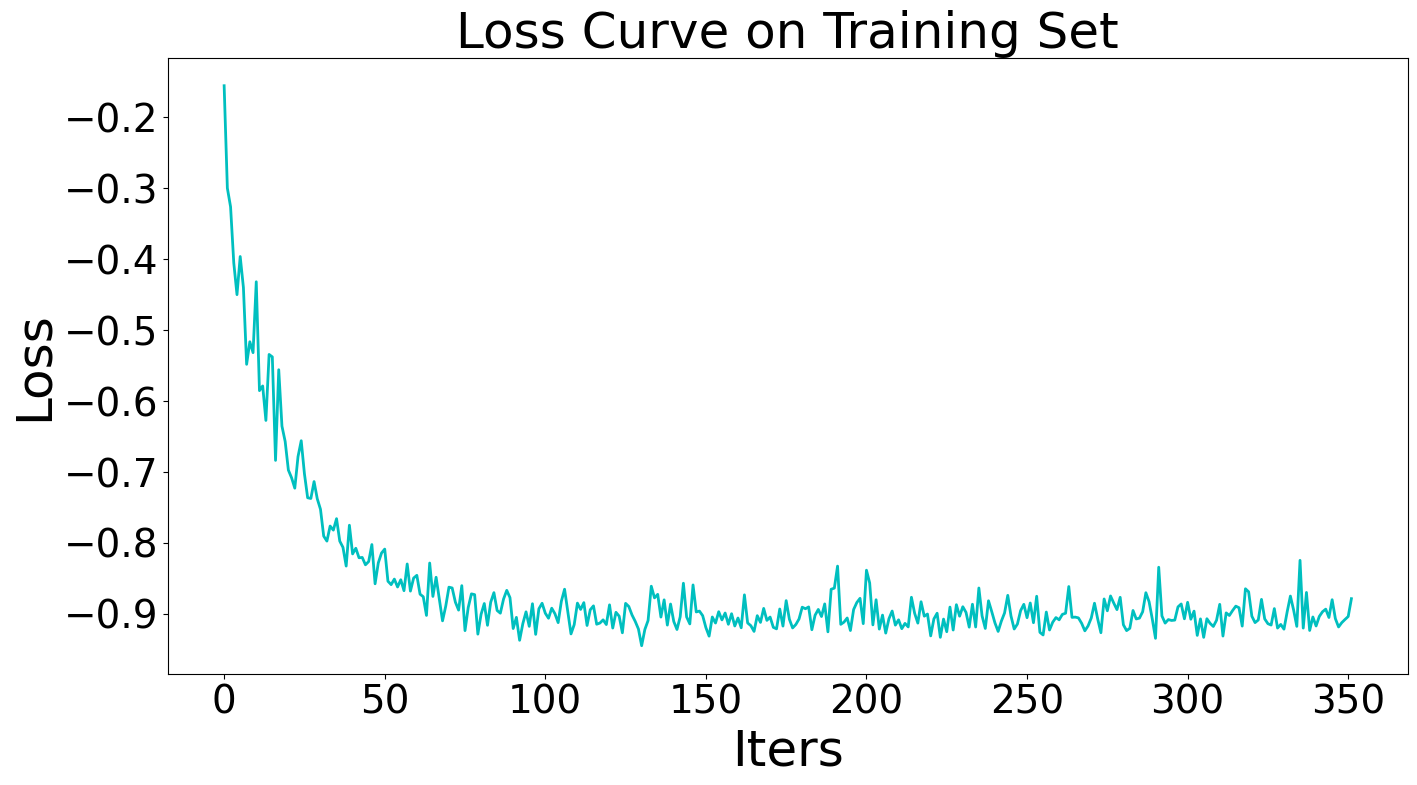

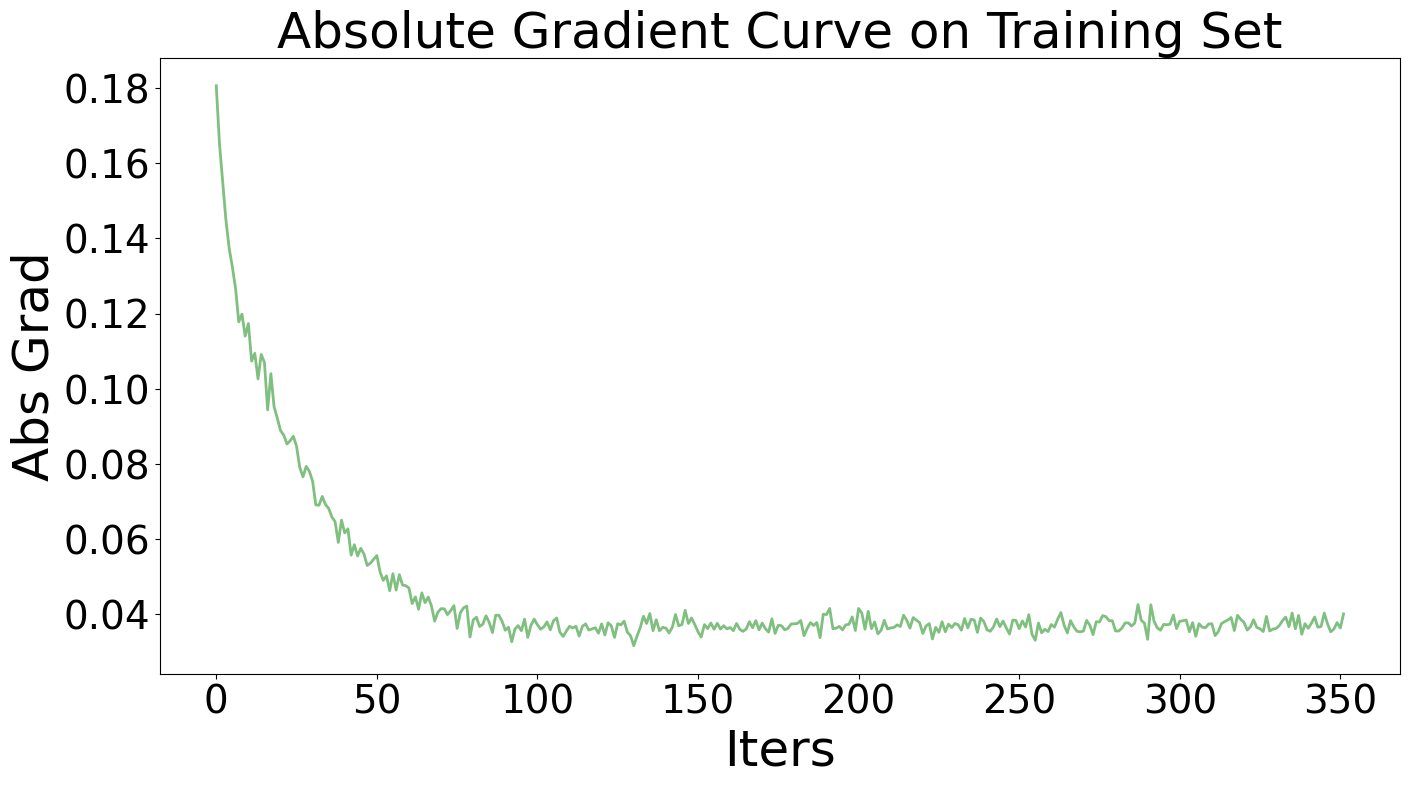

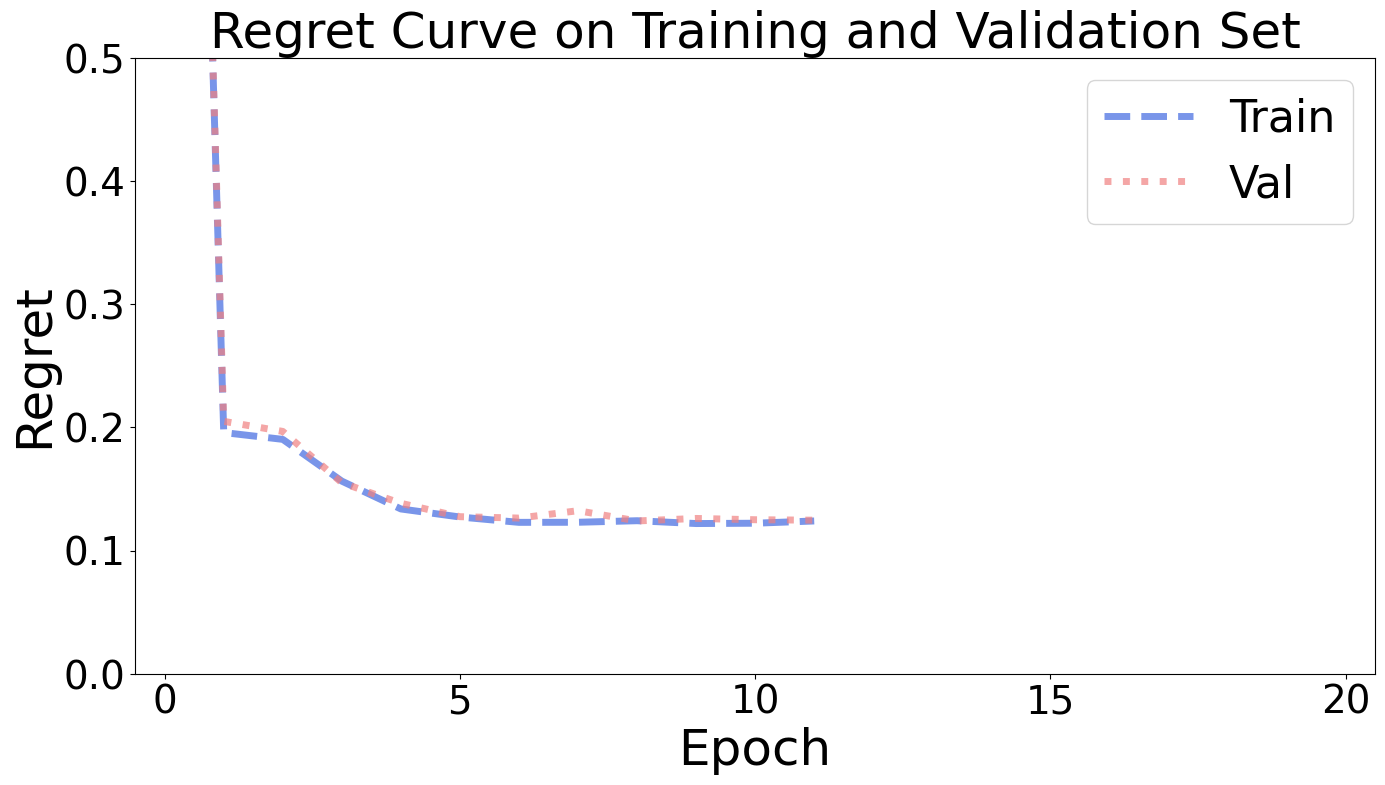

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [30]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1426%, Val Regret: 218.8037%


Epoch    0, Loss:  -0.7906:   5%|██▊                                                    | 1/20 [00:29<06:21, 20.09s/it]

Epoch   1, Train Regret:  20.2604%, Val Regret:  20.2133%


Epoch    1, Loss:  -0.9021:  10%|█████▌                                                 | 2/20 [00:48<05:51, 19.51s/it]

Epoch   2, Train Regret:  19.0234%, Val Regret:  19.1691%


Epoch    2, Loss:  -0.9179:  15%|████████▎                                              | 3/20 [01:07<05:27, 19.25s/it]

Epoch   3, Train Regret:  15.5783%, Val Regret:  15.5841%


Epoch    3, Loss:  -0.9018:  20%|███████████                                            | 4/20 [01:26<05:07, 19.23s/it]

Epoch   4, Train Regret:  13.4137%, Val Regret:  13.7960%


Epoch    4, Loss:  -0.9176:  25%|█████████████▊                                         | 5/20 [01:48<05:00, 20.01s/it]

Epoch   5, Train Regret:  12.6773%, Val Regret:  12.8053%


Epoch    5, Loss:  -0.8331:  30%|████████████████▌                                      | 6/20 [02:07<04:40, 20.01s/it]

Epoch   6, Train Regret:  12.2838%, Val Regret:  12.6337%


Epoch    6, Loss:  -0.9335:  35%|███████████████████▎                                   | 7/20 [02:26<04:13, 19.54s/it]

Epoch   7, Train Regret:  12.3452%, Val Regret:  13.1165%


Epoch    7, Loss:  -0.9302:  40%|██████████████████████                                 | 8/20 [02:45<03:50, 19.23s/it]

Epoch   8, Train Regret:  12.3938%, Val Regret:  12.2866%


Epoch    8, Loss:  -0.8706:  45%|████████████████████████▊                              | 9/20 [03:03<03:28, 18.97s/it]

Epoch   9, Train Regret:  12.1836%, Val Regret:  12.6253%


Epoch    9, Loss:  -0.8694:  50%|███████████████████████████                           | 10/20 [03:21<03:08, 18.80s/it]

Epoch  10, Train Regret:  12.2120%, Val Regret:  12.5324%


Epoch   10, Loss:  -0.8790:  55%|█████████████████████████████▋                        | 11/20 [03:41<03:01, 20.15s/it]


Epoch  11, Train Regret:  12.4117%, Val Regret:  12.4887%

Early Stop!
Training Elapsed Time: 96.35 Sec

Evaluation:
Test Regret: 12.6662%
Test Elapsed Time: 9.46 Sec


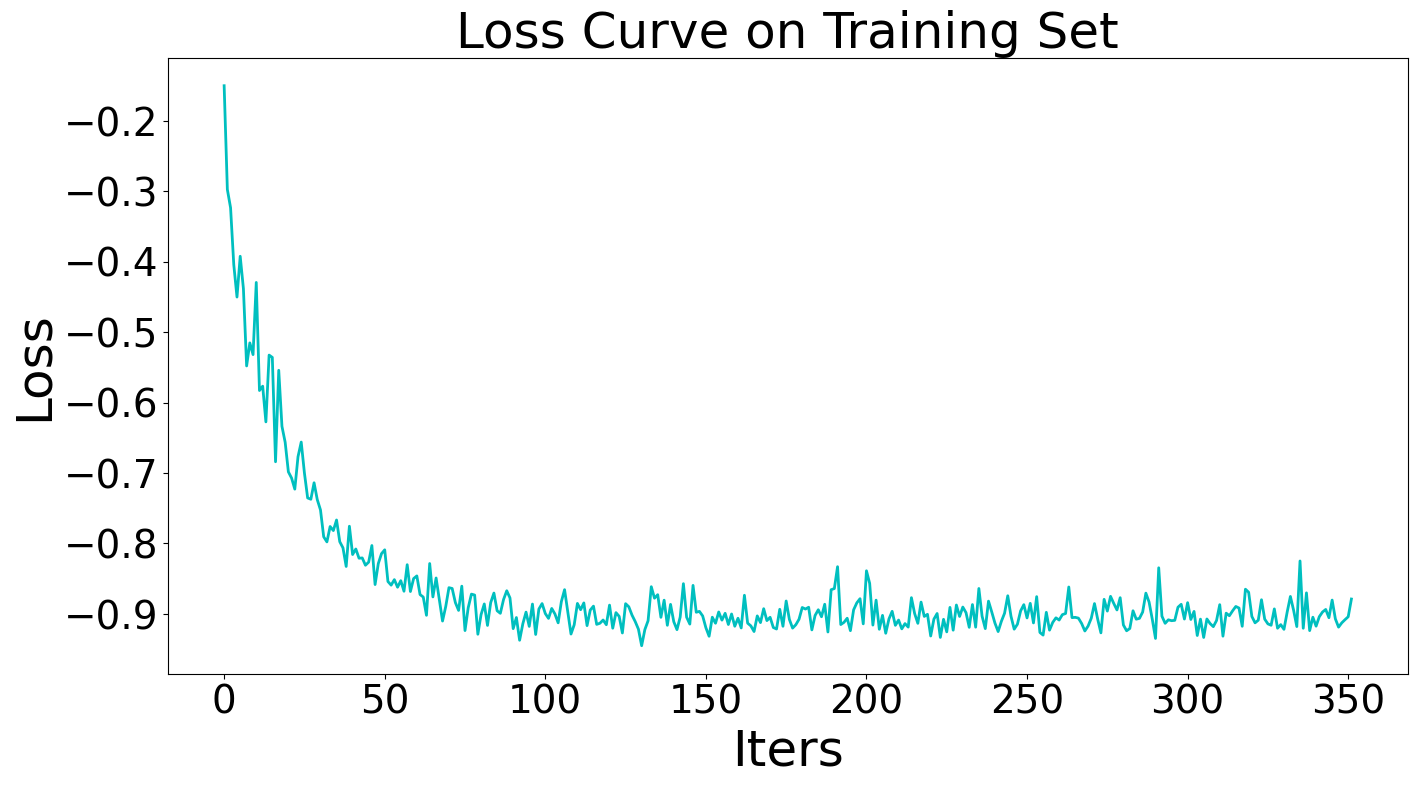

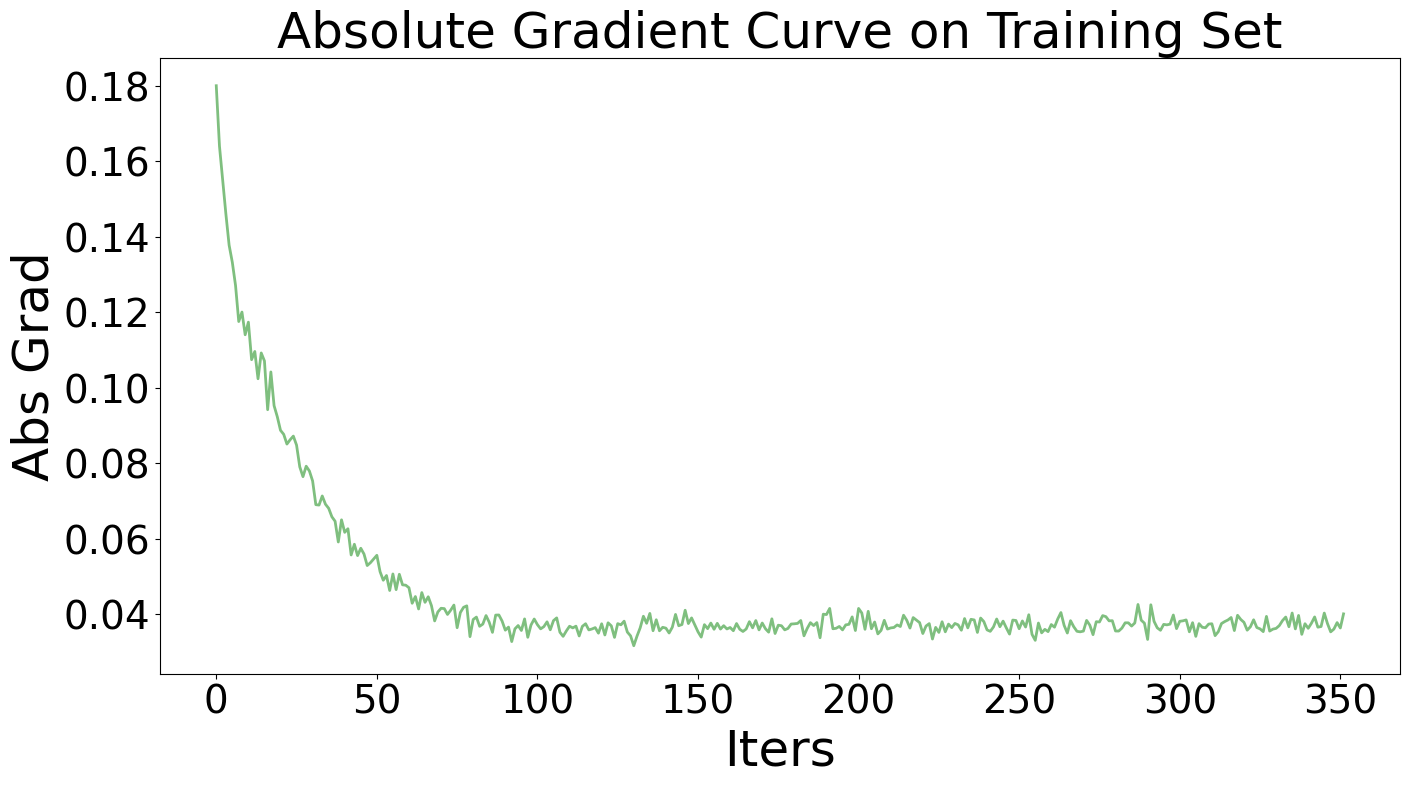

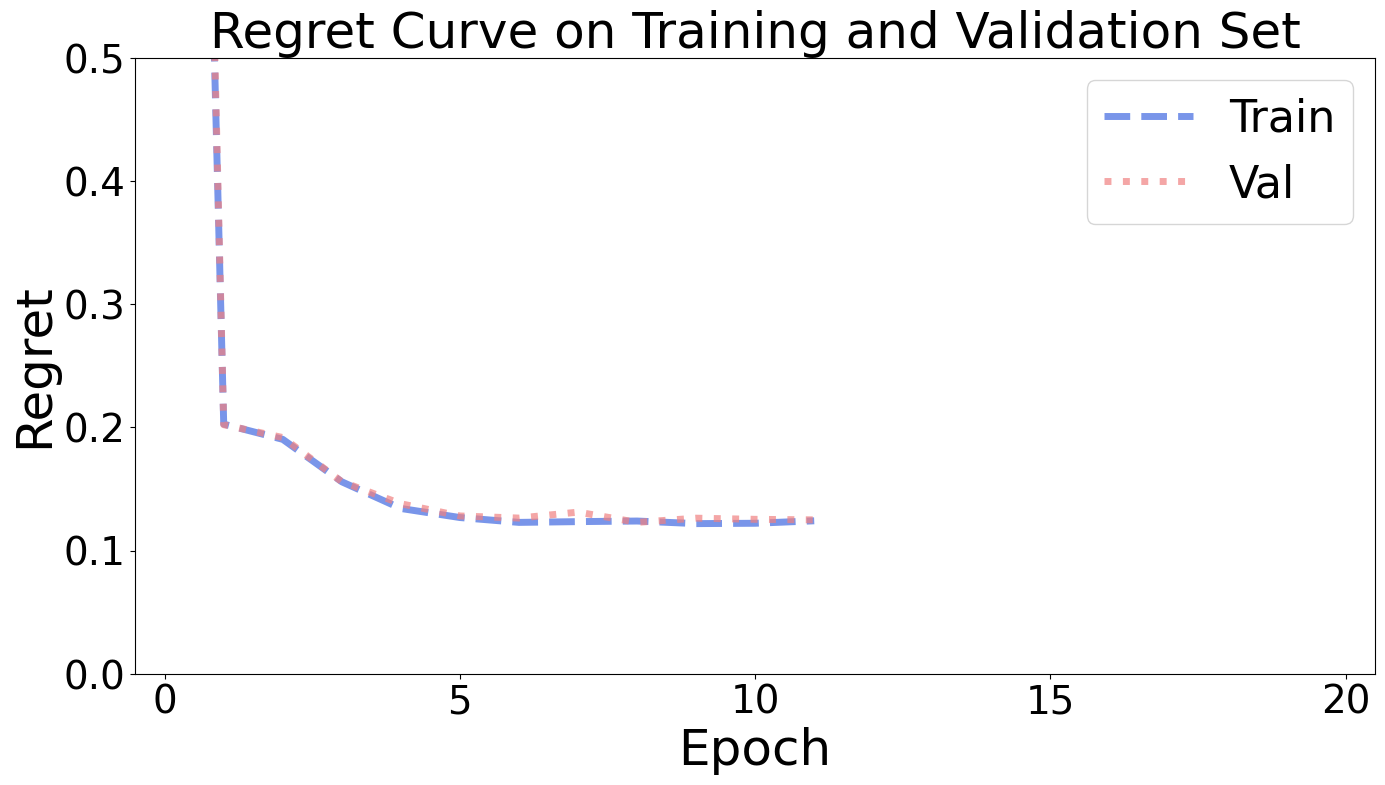

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1426%, Val Regret: 218.8037%


Epoch    0, Loss:  -0.7888:   5%|██▊                                                    | 1/20 [00:20<03:23, 10.70s/it]

Epoch   1, Train Regret:  20.1232%, Val Regret:  19.6724%


Epoch    1, Loss:  -0.9066:  10%|█████▌                                                 | 2/20 [00:30<03:11, 10.63s/it]

Epoch   2, Train Regret:  18.9767%, Val Regret:  19.2476%


Epoch    2, Loss:  -0.8499:  15%|████████▎                                              | 3/20 [00:40<02:59, 10.56s/it]

Epoch   3, Train Regret:  15.8356%, Val Regret:  16.0073%


Epoch    3, Loss:  -0.8249:  20%|███████████                                            | 4/20 [00:51<02:48, 10.51s/it]

Epoch   4, Train Regret:  13.6203%, Val Regret:  13.6546%


Epoch    4, Loss:  -0.9285:  25%|█████████████▊                                         | 5/20 [01:03<02:40, 10.67s/it]

Epoch   5, Train Regret:  12.6130%, Val Regret:  13.3478%


Epoch    5, Loss:  -0.8865:  30%|████████████████▌                                      | 6/20 [01:14<02:33, 11.00s/it]

Epoch   6, Train Regret:  12.2696%, Val Regret:  12.1371%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [01:24<02:21, 10.86s/it]

Epoch   7, Train Regret:  12.2170%, Val Regret:  12.3444%


Epoch    7, Loss:  -0.9392:  40%|██████████████████████                                 | 8/20 [01:34<02:08, 10.70s/it]

Epoch   8, Train Regret:  12.5274%, Val Regret:  12.7387%


Epoch    8, Loss:  -0.9074:  45%|████████████████████████▊                              | 9/20 [01:45<01:56, 10.57s/it]

Epoch   9, Train Regret:  12.1214%, Val Regret:  11.8941%


Epoch    9, Loss:  -0.9168:  50%|███████████████████████████                           | 10/20 [01:55<01:45, 10.53s/it]

Epoch  10, Train Regret:  12.2461%, Val Regret:  12.1780%


Epoch   10, Loss:  -0.8726:  55%|█████████████████████████████▋                        | 11/20 [02:06<01:34, 10.54s/it]

Epoch  11, Train Regret:  12.3261%, Val Regret:  12.4169%


Epoch   11, Loss:  -0.8895:  60%|████████████████████████████████▍                     | 12/20 [02:16<01:31, 11.40s/it]


Epoch  12, Train Regret:  12.1734%, Val Regret:  12.6911%

Early Stop!
Training Elapsed Time: 2.86 Sec

Evaluation:
Test Regret: 12.4398%
Test Elapsed Time: 8.43 Sec


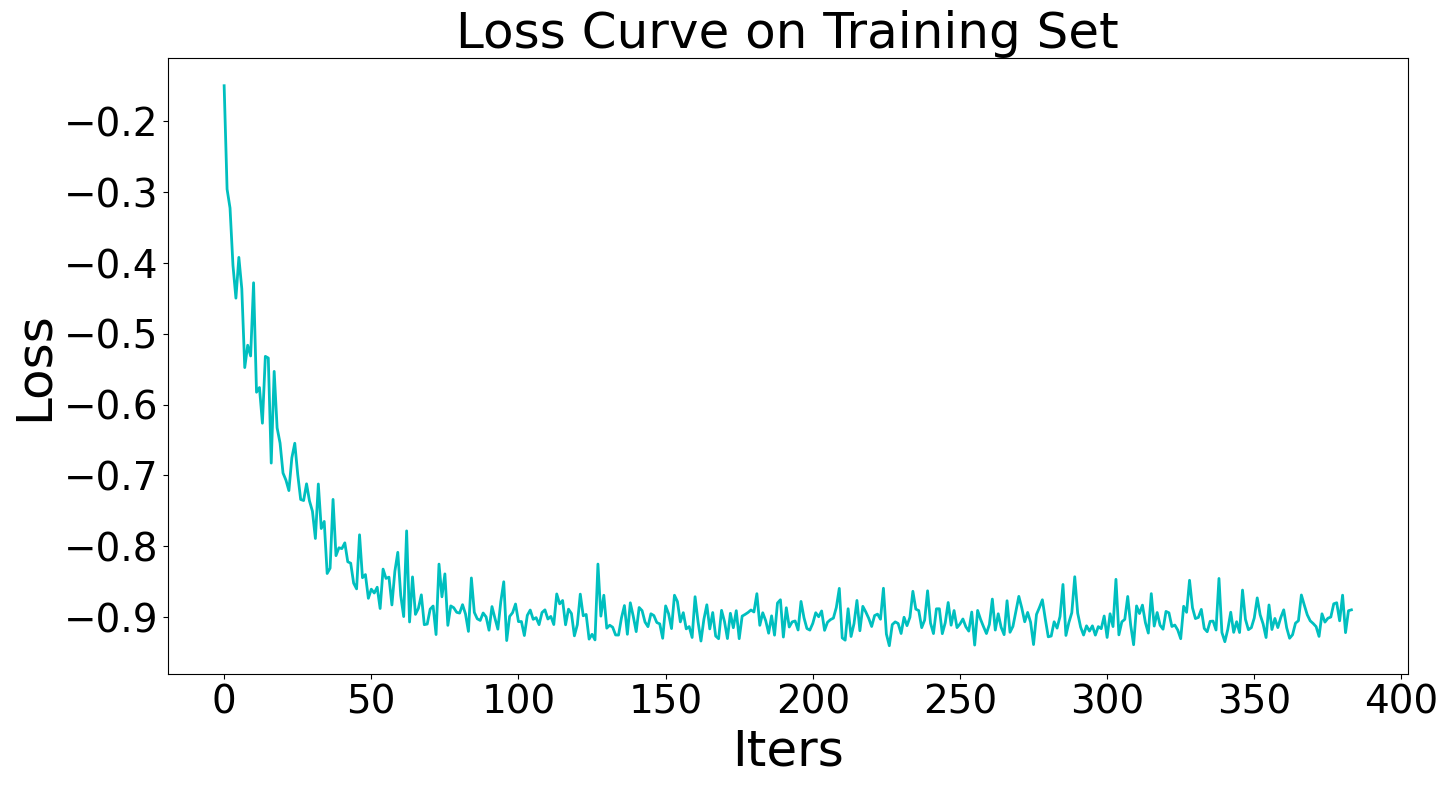

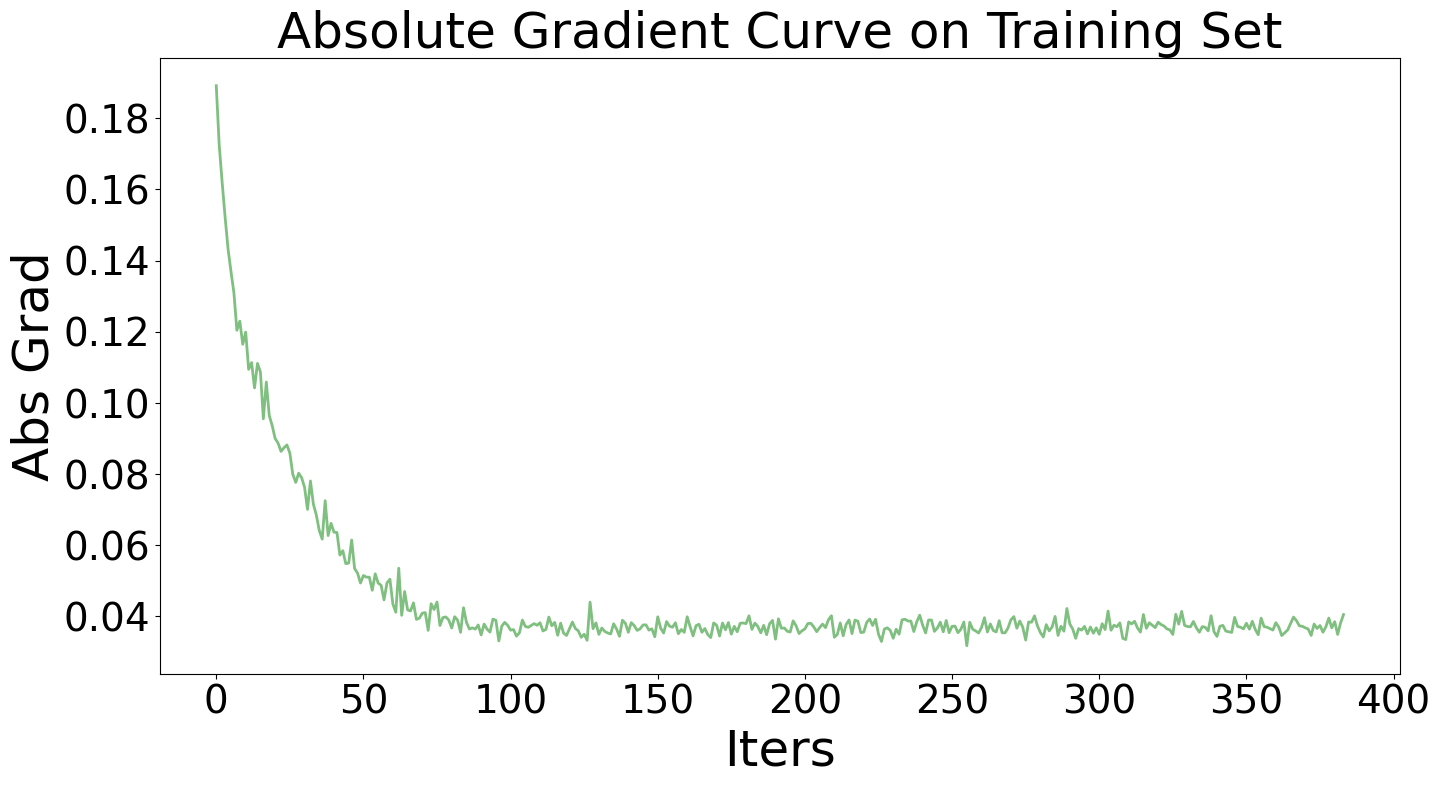

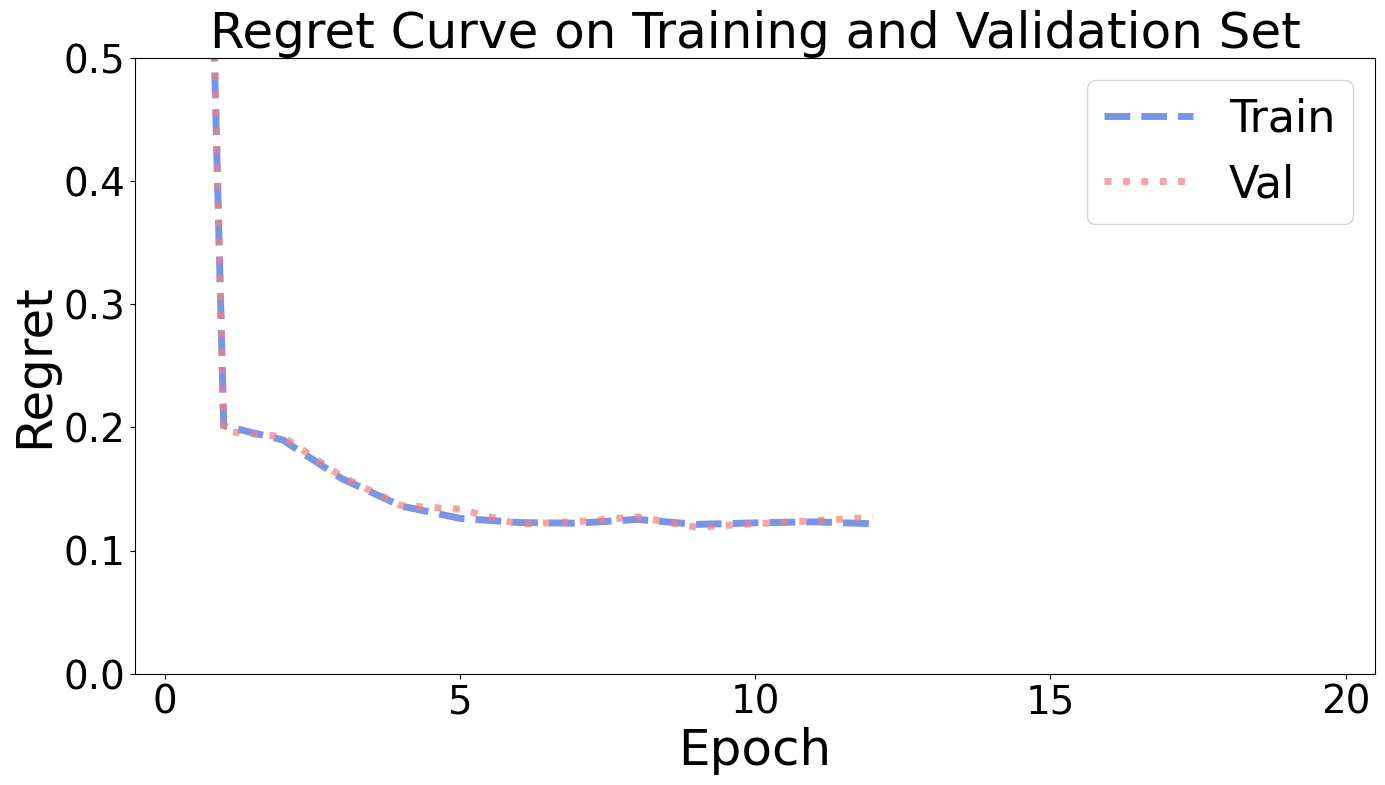

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [38]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 193.4241%, Val Regret: 198.0752%


Epoch    0, Loss:  -0.7906:   5%|██▊                                                    | 1/20 [00:28<05:48, 18.36s/it]

Epoch   1, Train Regret:  19.7569%, Val Regret:  19.9946%


Epoch    1, Loss:  -0.9073:  10%|█████▌                                                 | 2/20 [00:48<05:58, 19.93s/it]

Epoch   2, Train Regret:  18.7656%, Val Regret:  19.2948%


Epoch    2, Loss:  -0.8503:  15%|████████▎                                              | 3/20 [01:08<05:38, 19.93s/it]

Epoch   3, Train Regret:  15.5948%, Val Regret:  15.9092%


Epoch    3, Loss:  -0.8249:  20%|███████████                                            | 4/20 [01:28<05:19, 19.96s/it]

Epoch   4, Train Regret:  13.5571%, Val Regret:  13.7944%


Epoch    4, Loss:  -0.9285:  25%|█████████████▊                                         | 5/20 [01:47<04:51, 19.42s/it]

Epoch   5, Train Regret:  12.5729%, Val Regret:  13.1584%


Epoch    5, Loss:  -0.8866:  30%|████████████████▌                                      | 6/20 [02:05<04:26, 19.01s/it]

Epoch   6, Train Regret:  12.2773%, Val Regret:  12.0419%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [02:23<04:03, 18.77s/it]

Epoch   7, Train Regret:  12.1770%, Val Regret:  12.3516%


Epoch    7, Loss:  -0.9392:  40%|██████████████████████                                 | 8/20 [02:42<03:44, 18.69s/it]

Epoch   8, Train Regret:  12.5270%, Val Regret:  12.6615%


Epoch    8, Loss:  -0.9074:  45%|████████████████████████▊                              | 9/20 [03:00<03:24, 18.58s/it]

Epoch   9, Train Regret:  12.1276%, Val Regret:  11.8989%


Epoch    9, Loss:  -0.9168:  50%|███████████████████████████                           | 10/20 [03:18<03:04, 18.41s/it]

Epoch  10, Train Regret:  12.2258%, Val Regret:  12.2114%


Epoch   10, Loss:  -0.8726:  55%|█████████████████████████████▋                        | 11/20 [03:37<02:46, 18.46s/it]

Epoch  11, Train Regret:  12.3312%, Val Regret:  12.4969%


Epoch   11, Loss:  -0.8894:  60%|████████████████████████████████▍                     | 12/20 [03:56<02:37, 19.67s/it]


Epoch  12, Train Regret:  12.1772%, Val Regret:  12.8151%

Early Stop!
Training Elapsed Time: 101.11 Sec

Evaluation:
Test Regret: 12.4255%
Test Elapsed Time: 8.52 Sec


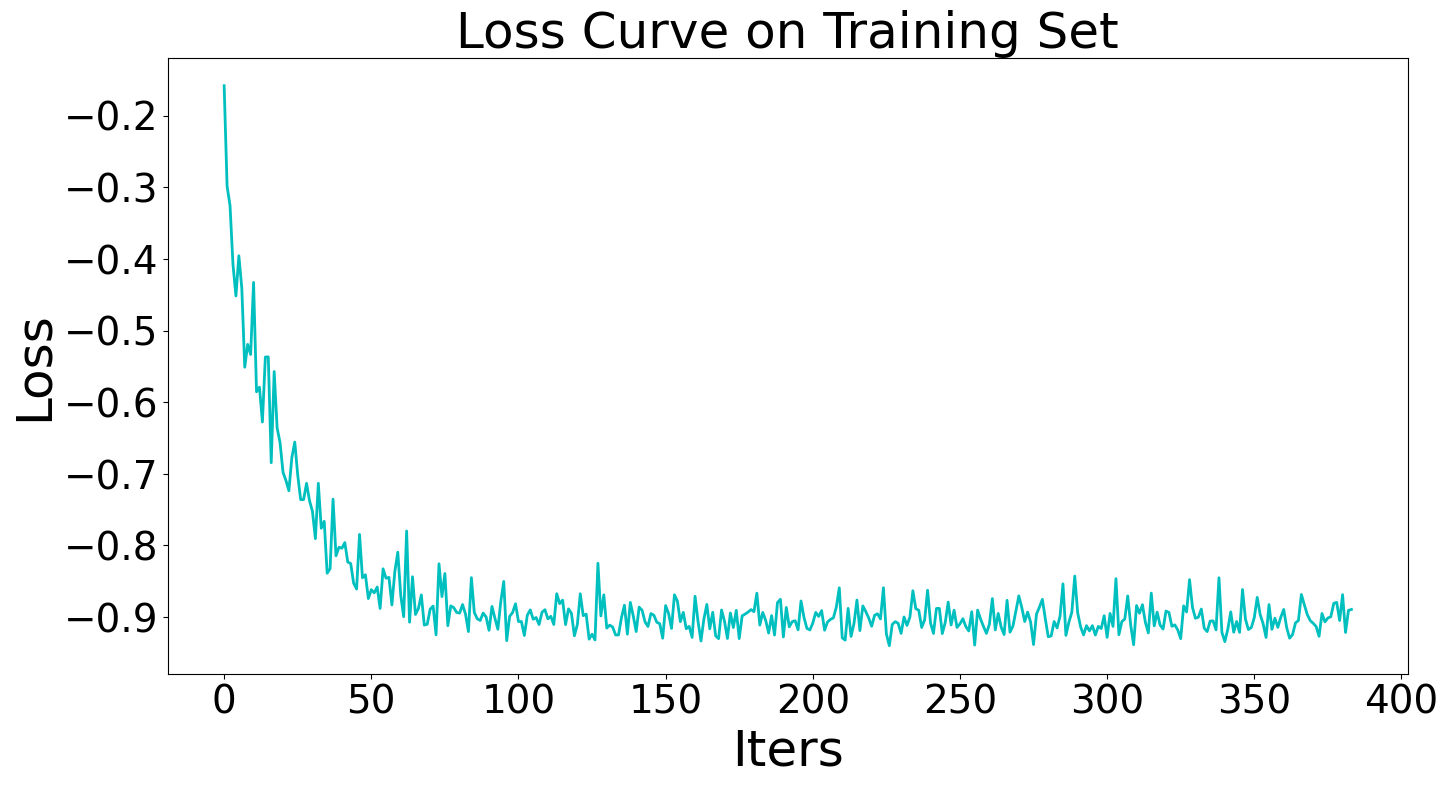

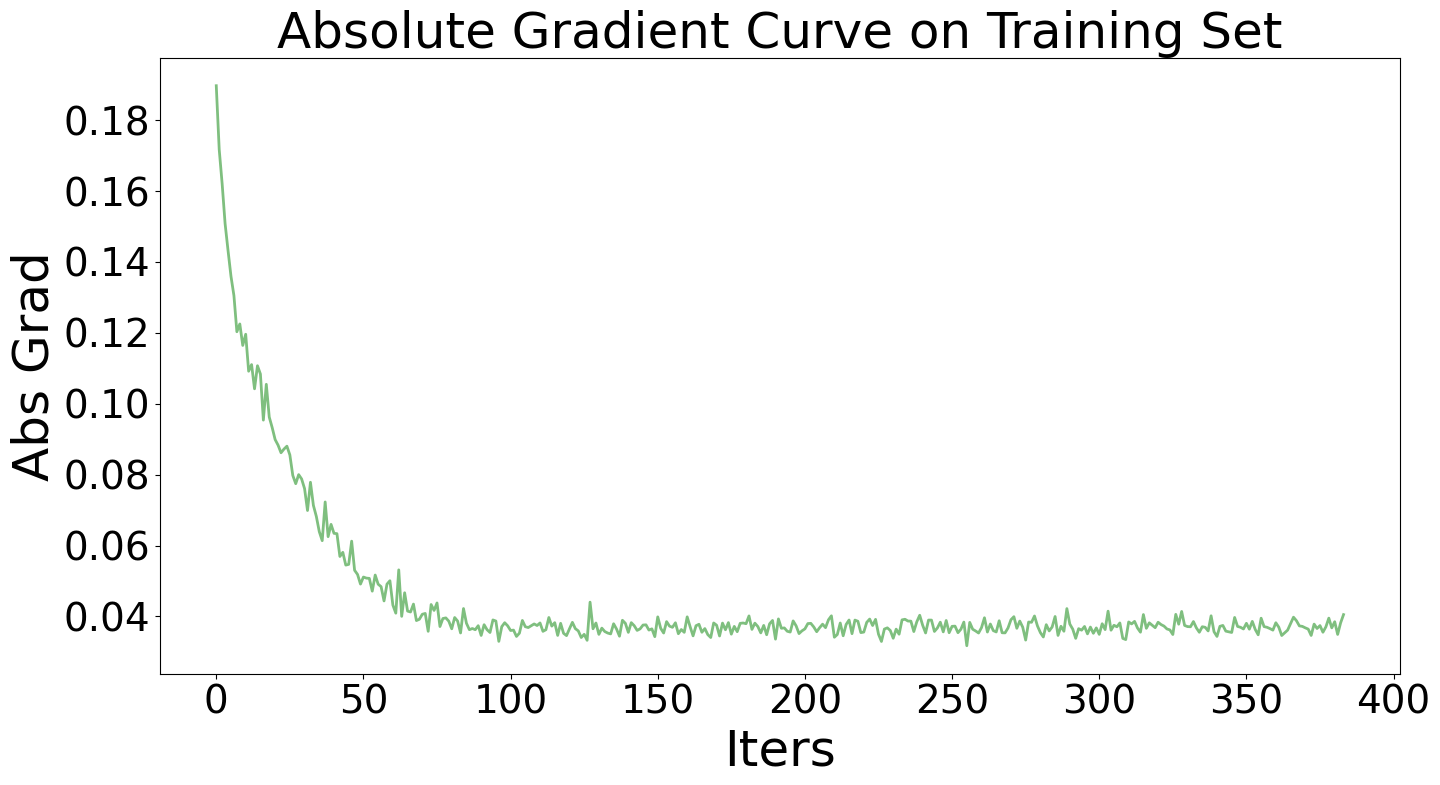

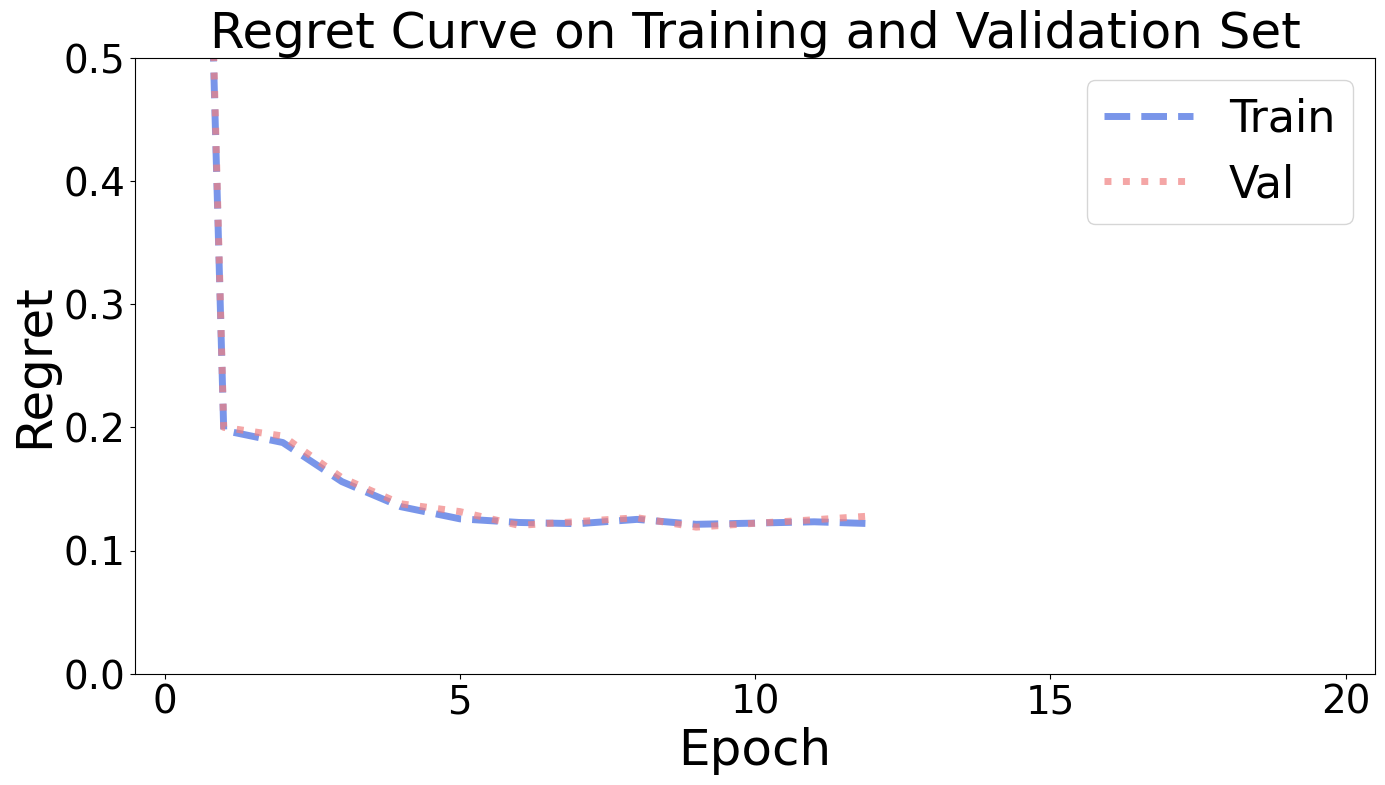

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)